In [2]:
#Array packages
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc4

from scipy.stats import kendalltau
import pymannkendall as mk

#plots
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import scienceplots

plt.style.use(['science','no-latex','bright'])

#Progress meter
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Directories
import os
import glob
import dask
#import h5netcdf
import scipy

import os
os.chdir(r"E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\1_Streamflow")
print(os.getcwd())

E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\1_Streamflow


In [8]:
gauge_info=pd.read_csv('3_Data/Data_p/2_Station/gauge_info_p.csv',index_col=0)
gauge_info1=gauge_info.iloc[:,1:5]
gauge_sf=xr.open_dataset(f'3_Data/Data_p/2_Station/Gauge_streamflow.nc')
guage_ind=xr.open_mfdataset(f'3_Data/Data_p/2_Station/Gauge_indices.nc')
ILDAS_sf=xr.open_mfdataset(f'3_Data/Data_p/1_ILDAS/ILDAS_station_streamflow.nc')
ILDAS_ind=xr.open_mfdataset(f'3_Data/Data_p/1_ILDAS/ILDAS_station_indices.nc')

data1=sorted(glob.glob(f'3_Data/Data_r/1_ILDAS/*.nc*'))
d_IL = xr.open_mfdataset(data1, combine='by_coords',engine='netcdf4', parallel=True,chunks={'time': 'auto'})
d_IL=d_IL.resample(time='M').mean().compute()

c:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\xarray\core\groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


## 1 Gauge investigation


#### 1.1 Missing data percentage

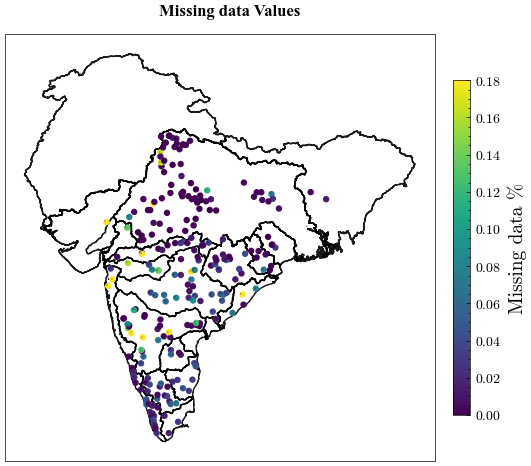

In [11]:
station=gauge_info['Station'].to_list()
gauge_info1['missing_per']=1-(gauge_info['Streamflow_Entries']/gauge_info['Expected_entries'])

fig,ax=plt.subplots(figsize=(6,6),subplot_kw={'projection':ccrs.PlateCarree()})
south_asia=gpd.read_file(r'3_Data\Data_p\3_Shapefiles\south_asia_p.shp')

south_asia.plot(ax=ax,color = 'none',edgecolor = 'Black',linewidth=1,alpha=0.9)
sc=ax.scatter(gauge_info1['Longitude'],gauge_info1['Latitude'],c=gauge_info1['missing_per'],s=13,vmin=0,vmax=0.18)  #corr or rmse
#sc1=ax.scatter(gauge_info1['lon'],gauge_info1['lat'],c=gauge_info1['diff'],s=18)
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.036, pad=0.04,label = 'Missing %')  #rmse - 0 -1000
cbar.set_label(f'Missing data %', fontsize=14)
for i, row in gauge_info1.iterrows():
    ax.text(row['Longitude'],row['Latitude'], f"{i}", fontsize=0.01, ha='right')

fig.suptitle(f'Missing data Values', fontsize=12, y=0.9, fontweight='bold', fontname='Times New Roman')
plt.savefig(f'2_Streamflow_Analysis/0_Checks/outputs/1.1 Missing data.jpeg')


#### 1.2 Total zeroes (To check if perennial or not)

In [12]:
for s,stn in enumerate(station):

    strt_=pd.to_datetime(gauge_info.loc[s,'Start_date'])
    end_= pd.to_datetime(gauge_info.loc[s,'End_date'])

    arr=gauge_sf['streamflow'].sel(station=stn,time=slice(strt_,end_)).values
    gauge_info1.loc[s,['nan_values']]=np.sum(np.isnan(arr))
    gauge_info1.loc[s,['0_val']]=np.sum(arr==0)


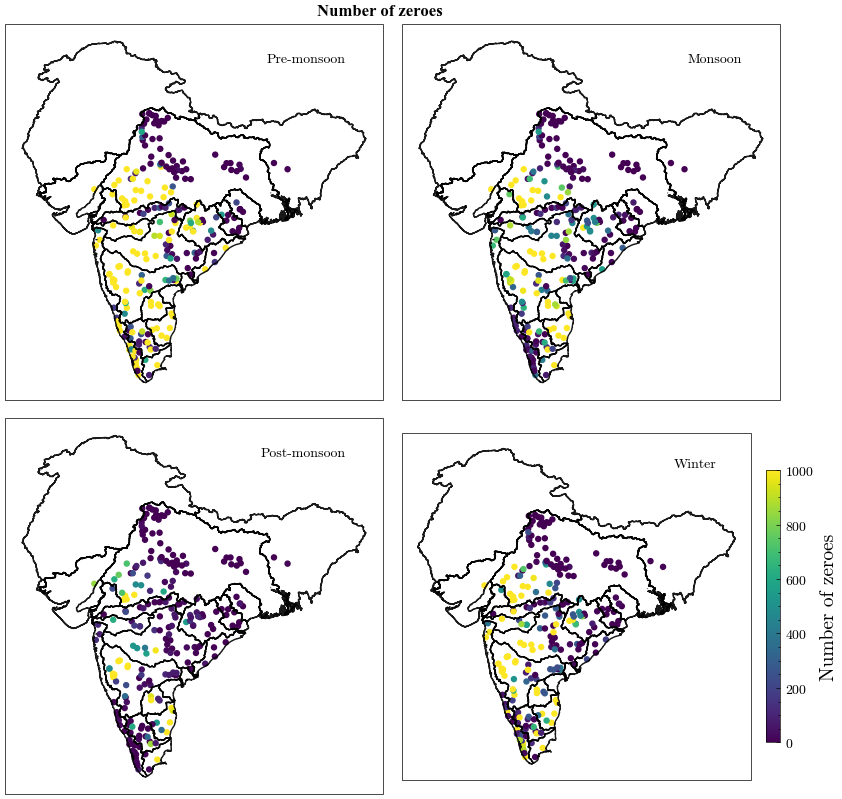

In [31]:
fig,ax=plt.subplots(2,2,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()})
ax1=ax.flatten()


for i,ssn in enumerate(season_n):
    for s,stn in enumerate(station):

        strt_=pd.to_datetime(gauge_info.loc[s,'Start_date'])
        end_= pd.to_datetime(gauge_info.loc[s,'End_date'])

        arr=gauge_sf['streamflow'].sel(station=stn,time=slice(strt_,end_))
        arr=arr.sel(time=arr['time.month'].isin([ssn])).values
        gauge_info1.loc[s,['nan_values']]=np.sum(np.isnan(arr))
        gauge_info1.loc[s,['0_val']]=np.sum(arr==0)

    sc=ax1[i].scatter(gauge_info1['Longitude'],gauge_info1['Latitude'],c=gauge_info1['0_val'],s=13,vmin=0,vmax=1000)  #corr or rmse
    south_asia.plot(ax=ax1[i],color = 'none',edgecolor = 'Black',linewidth=1,alpha=0.9)
    ax1[i].text(0.9,0.9,f'{season[i]}',transform=ax1[i].transAxes,ha='right')
fig.subplots_adjust(bottom=None, left=None, top=None, right=None, wspace=0.05, hspace=0.05)  # 
cbar = fig.colorbar(sc, orientation='vertical', fraction=0.036, pad=0.04)  #rmse - 0 -1000
cbar.set_label(f'Number of zeroes', fontsize=14)

fig.suptitle(f'Number of zeroes', fontsize=12, y=0.9, fontweight='bold', fontname='Times New Roman')
plt.savefig(f'2_Streamflow_Analysis/0_Checks/outputs/1.2 No zeroes.jpeg')

c:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\xarray\core\groupby.py:532: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


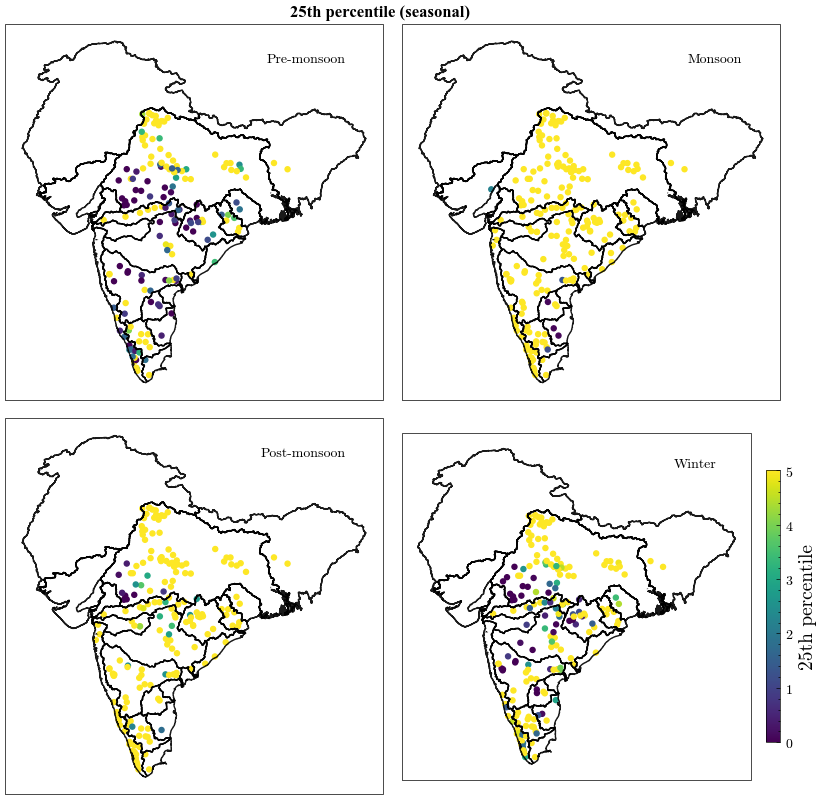

In [21]:
## Check perinniel or not. Consider monthly data seasonally and calculate the 25% of each season
season=['Pre-monsoon','Monsoon','Post-monsoon','Winter']
season_n=[[3,4,5],[6,7,8,9],[10,11],[12,1,2]]

gauge_sf_M=gauge_sf.resample(time='M').mean()

fig,ax=plt.subplots(2,2,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()})
ax1=ax.flatten()



for i,ssn in enumerate(season_n):
    for s,stn in enumerate(station):

        strt_=pd.to_datetime(gauge_info.loc[s,'Start_date'])
        end_= pd.to_datetime(gauge_info.loc[s,'End_date'])

        ds=gauge_sf_M['streamflow'].sel(station=stn,time=slice(strt_,end_))
        arr=ds.sel(time=ds['time.month'].isin([ssn])).resample(time='YE').mean()
        gauge_info1.loc[s,['25th percentile']]=np.quantile(arr,0.25)

    sc=ax1[i].scatter(gauge_info1['Longitude'],gauge_info1['Latitude'],c=gauge_info1['25th percentile'],s=13,vmin=0,vmax=5)  #corr or rmse
    south_asia.plot(ax=ax1[i],color = 'none',edgecolor = 'Black',linewidth=1,alpha=0.9)
    ax1[i].text(0.9,0.9,f'{season[i]}',transform=ax1[i].transAxes,ha='right')
fig.subplots_adjust(bottom=None, left=None, top=None, right=None, wspace=0.05, hspace=0.05)  # 
cbar = fig.colorbar(sc, orientation='vertical', fraction=0.036, pad=0.04)  #rmse - 0 -1000
cbar.set_label(f'25th percentile', fontsize=14)
fig.suptitle(f'25th percentile (seasonal)', fontsize=12, y=0.9, fontweight='bold', fontname='Times New Roman')
plt.savefig(f'2_Streamflow_Analysis/0_Checks/outputs/2.2 25th percentile.jpeg')


###

### MAP info check

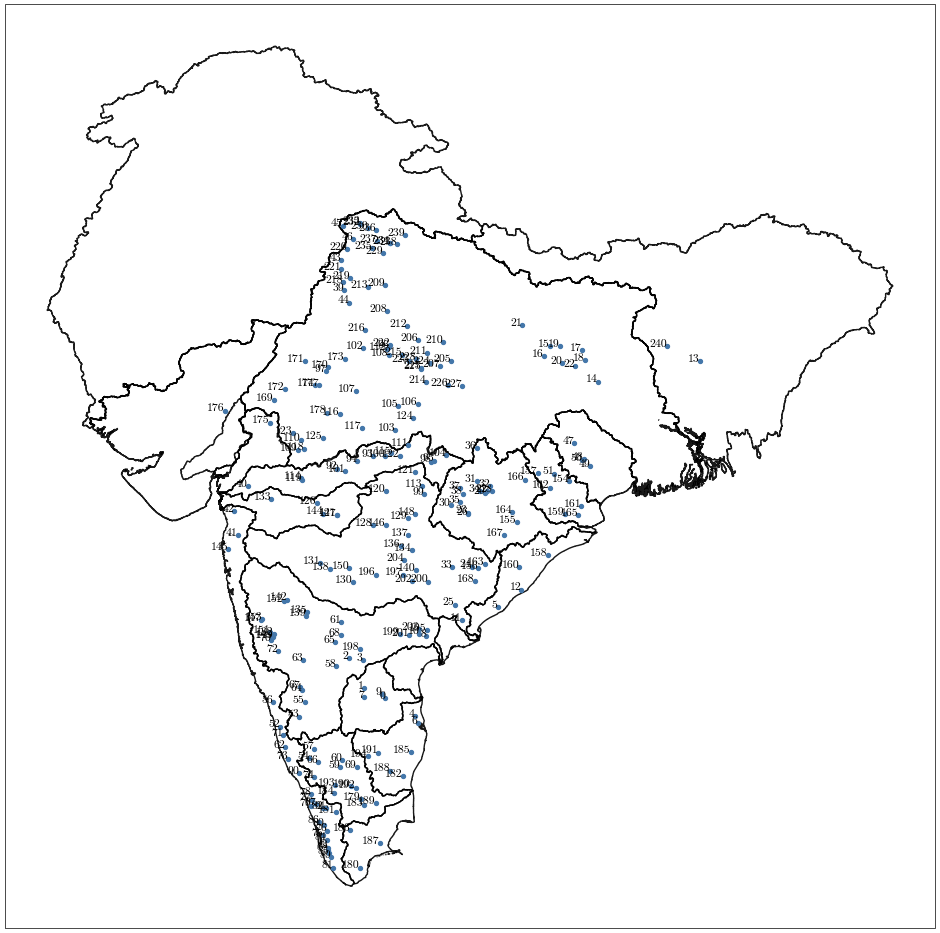

In [27]:
fig,ax=plt.subplots(figsize=(12,12),subplot_kw={'projection':ccrs.PlateCarree()})
south_asia=gpd.read_file(r'3_Data\Data_p\3_Shapefiles\south_asia_p.shp')

south_asia.plot(ax=ax,color = 'none',edgecolor = 'Black',linewidth=1,alpha=0.9)
sc=ax.scatter(gauge_info1['Longitude'],gauge_info1['Latitude'],s=8)

for i, row in gauge_info1.iterrows():
    ax.text(row['Longitude'],row['Latitude'], f"{i}", fontsize=8.5, ha='right')

plt.savefig(f'2_Streamflow_Analysis/0_Checks/outputs/MAP_info.jpeg')
    

In [35]:
gauge_info.loc[[176],:]

,GaugeID,Station,Latitude,Longitude,River Name/ Tributory/ SubTributory,Basin,State,Start_date,End_date,Streamflow_Entries,Expected_entries,Period_length,nan_values,0_val
176,IWM-gauge-814,Banas at abu road,24.4939,72.7917,Banas,West flowing rivers of Kutchh and Saurashtra i...,Rajasthan,1980-06-23 00:00:00,2012-06-07 00:00:00,8580,11673.0,32.0,3093.0,5730.0
